### Tutorial 2: Clustering on mouse_anterior_posterior_brain_merged

In this tutorial, we will show how to use the stCAMBL model to perform spatial transcriptomic analysis of mouse brain slices. Relevant data can be obtained from https://drive.google.com/drive/folders/141__9Q4zYK_6A4stKsOE5WikIHgxFkhk

**Import the relevant python analysis package**

In [7]:
import scanpy as sc
import pandas as pd
from sklearn import metrics
import torch
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings('ignore')
import stCAMBL
import os
#Please change this path to your local R environment path
os.environ['R_HOME'] = '/data3/wkcui/env/anaconda3/envs/stCAMBL/lib/R'

**Read data and perform data preprocessing**

In [8]:
dataset = 'Mouse_brain'
random_seed = 2050
stCAMBL.set_seed(random_seed)
device = 'cuda:1' if torch.cuda.is_available() else 'cpu'
# read data
# Please change this path to your local data path
file_path = '/data3/yfchen/stCAMBL/data/mouse_anterior_posterior_brain_merged.h5ad'
n_clusters = 26
adata = sc.read_h5ad(file_path)
adata.var_names_make_unique()
# preprocess data
sc.pp.filter_genes(adata, min_cells=50)
sc.pp.filter_genes(adata, min_counts=10)
sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=2000)

adata = adata[:, adata.var['highly_variable'] == True]

sc.pp.scale(adata)


**Perform stCAMBL analysis**

In [9]:
from sklearn.decomposition import PCA
adata_X = PCA(n_components=200, random_state=42).fit_transform(adata.X)
adata.obsm['X_pca'] = adata_X

graph_dict = stCAMBL.graph_construction(adata, 12)
model = stCAMBL.stCAMBL(dataset, adata.obsm['X_pca'], graph_dict, device=device)
# Begin to train the model
model.train_model(epochs=400)
stCAMBL_feat, defeat, _, _, _ = model.process()
adata.obsm['emb'] = stCAMBL_feat

100%|██████████| 400/400 [01:49<00:00,  3.65it/s]


**clustering**

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


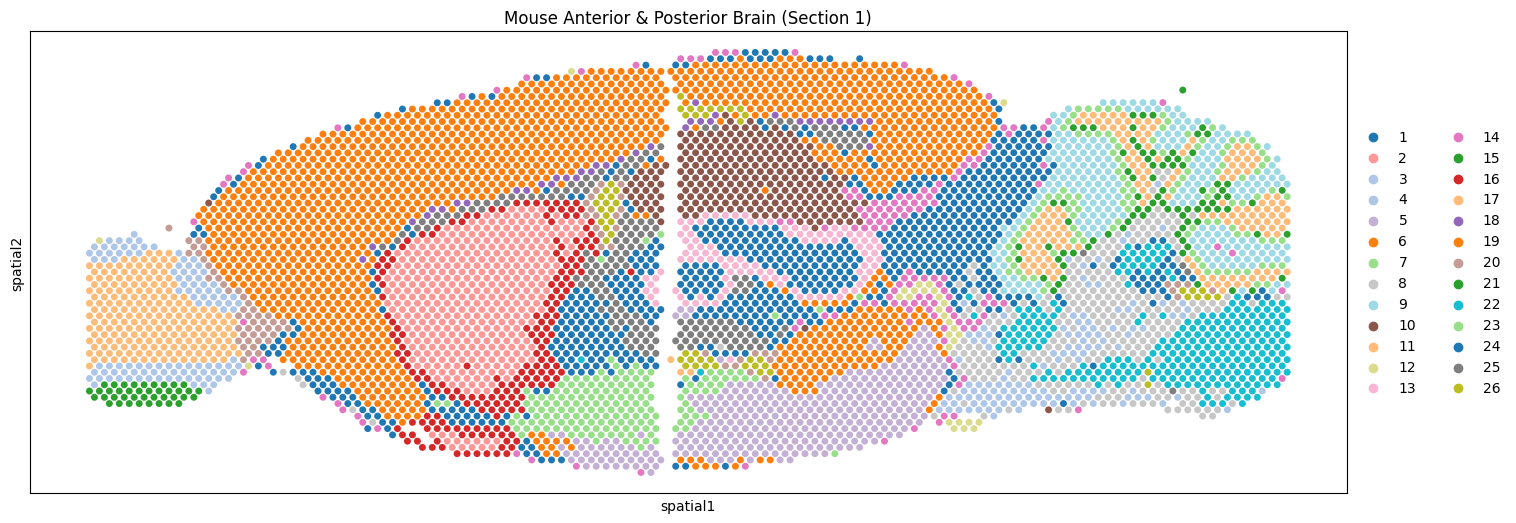

In [10]:
radius = 50
tool = 'mclust' 
# clustering
from stCAMBL.clust_func import clustering
clustering(adata, n_clusters, radius=radius, method=tool, refinement=True)

# plotting spatial clustering result
adata.obsm['spatial'][:,1] = -1*adata.obsm['spatial'][:,1]
import seaborn as sns
rgb_values = sns.color_palette("tab20", len(adata.obs['mclust'].unique()))
color_fine = dict(zip(list(adata.obs['mclust'].unique()), rgb_values))

plt.rcParams["figure.figsize"] = (17, 6)
sc.pl.embedding(adata, basis="spatial",
                color="mclust",
                s=100,
                palette=color_fine,
                show=True,
                title='Mouse Anterior & Posterior Brain (Section 1)')


